# RNN Moneymaker

In [1]:
import csv
import re
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime

import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
root_path = 'scrape/data/'

In [3]:
raw_data = {}
all_files = os.listdir(root_path)

for i, filename in enumerate(all_files):
    
    # Only load 1/N of all stocks
    if i % 3 == 0:
    
        len_stocks = len(all_files)
        print("Loading stock {}/{} ({})   ".format(i + 1, len_stocks, filename), end='\r')
        
        with open(root_path + filename) as f:
            if not filename.startswith('.'):
                data = json.load(f)
                                
                prices = []
                dates = []
                for k, v in data.items():
                    prices.append(np.array([ float(i[1]) for i in v.items() if i[0] != "5. volume" ]))
                    dates.append(k)
                
                # reverse so that data is increasing in time
                prices.reverse()
                dates.reverse()
                raw_data[filename.split('.')[0]] = (prices, dates)

print("")
print("Total number of stocks: " + str(len(raw_data)))

Loading stock 3562/3562 (PRVB.txt)    
Total number of stocks: 1188


In [4]:
X_train = []
y_train = []
X_val = []
y_val = []
window_size = 122

plen = 0
means_stds = {}
for i, items in enumerate(raw_data.items()):
    print("({}/{})".format(i, len(raw_data.items())), end="\r")
    k, v = items
    prices, _ = v
    if len(prices) < window_size + 1:
        continue
    
    prices = torch.tensor(prices).float()
    mean = torch.mean(prices)
    std = torch.std(prices)
    prices = (prices - mean) / std
    means_stds[k] = (mean, std)
    
    plen += prices.shape[0] - window_size - 1
    if i % 5 != 0:
        for j in range(prices.shape[0] - window_size - 1):
            X_train.append(prices[j:j+window_size].unsqueeze(0))
            y_train.append(prices[j+window_size][3].item())
    else:
        for j in range(prices.shape[0] - window_size - 1):
            X_val.append(prices[j:j+window_size].unsqueeze(0))
            y_val.append(prices[j+window_size][3].item())

print("Converting to torch tensors...")
X_train = torch.cat(X_train)
y_train = torch.tensor(y_train).unsqueeze(1)
X_val = torch.cat(X_val)
y_val = torch.tensor(y_val).unsqueeze(1)
print("Done")

Converting to torch tensors...
Done


In [5]:
print("X_train shape: \t", X_train.shape)
print("X_val shape: \t", X_val.shape)
print("y_train shape: \t", y_train.shape)
print("y_val shape: \t", y_val.shape)

# false means that something is wrong
print(plen == X_train.shape[0] + X_val.shape[0])

X_train shape: 	 torch.Size([2252037, 122, 4])
X_val shape: 	 torch.Size([551136, 122, 4])
y_train shape: 	 torch.Size([2252037, 1])
y_val shape: 	 torch.Size([551136, 1])
True


In [6]:
# print("old:")
# print(X.shape)
# print(y.shape)

# a = torch.sum(torch.sum(X == X, dim=1), dim=1) != 0
# b = (y == y) != 0

# c = a if torch.sum(a) < torch.sum(b) else b

# X = X[c]
# y = y[c] # To make y (N, 1) from (N,)

# print("new:")
# print(X.shape)
# print(y.shape)

### Training a RNN

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [19]:
batch_size = 32
dataset = Dataset(X_train, y_train)
loader = DataLoader(dataset, batch_size)

In [9]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.drop(out)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
input_dim = 4
hidden_dim = 20
output_dim = 1

In [11]:
model = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
epoch = 0

### Load a pre-existing model for further training or prediction

In [24]:
model = RNNClassifier(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load('assets/partial_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.train()

FileNotFoundError: [Errno 2] No such file or directory: 'assets/partial_model.pt'

### Train the model

In [ ]:
t0 = time.time()
num_epochs = 3
for ep in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(loader):
        print("{}/{}".format(i, X_train.shape[0]), end='\r')
        optimizer.zero_grad()
        outputs = model(data[0])
        loss = criterion(outputs, data[1])
        loss.backward()
        optimizer.step()
    
        if i % 1000==0:
            with torch.no_grad():
                model.eval()
                train_losses.append(loss.item())
                pXval = model(X_val)
                vloss = criterion(pXval, y_val)
                val_losses.append(vloss.item())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, 'assets/partial_model.pt')

                print("training loss: {:<3.3f} \t val loss: {:<3.3f}".format(loss, vloss))
                model.train()

    with torch.no_grad():
        model.eval()
        pXval = model(X_val)
        vloss = criterion(pXval, y_val)
        val_losses.append(vloss.item())
        epoch += 1    
        tend = time.time()
        print('epoch: {:<3d} \t time: {:<3.2f} \t val loss: {:<3.3f}'.format(epoch, 
                tend - tstart, vloss.item()))
time_total = time.time() - t0
print('Total time: {:4.3f}, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

In [146]:
torch.save(model, 'assets/model.pt')

/usr/local/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model evaluation

In [10]:
model = torch.load('assets/model.pt')

In [11]:
t_losses = [i for i in train_losses if i < 4000]
plt.plot(t_losses)
plt.plot(val_losses)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend(['train', 'val'])

NameError: name 'train_losses' is not defined

In [17]:
model.eval()

RNNClassifier(
  (rnn): LSTM(4, 20, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [13]:
pred = model(X_val)
print(criterion(pred, y_val))

NameError: name 'X_val' is not defined

### Model predictions compared to standard deviations

Text(0.5, 1.0, 'std difference')

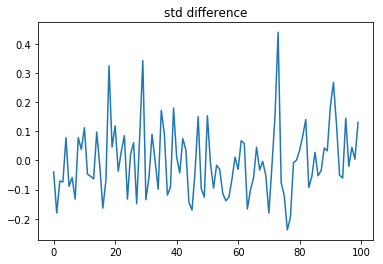

In [150]:
pred = model(X_val)

plt.plot((pred - y_val).detach()[1000:1100])
plt.title('std difference')

### Model predictions compared to actual price

In [151]:
pred_abs = pred * X_std[val_selector][:,:,3] + X_mean[val_selector][:,:,3]
y_val_abs = y_val * X_std[val_selector][:,:,3] + X_mean[val_selector][:,:,3]

plt.plot((pred_abs - y_val_abs).detach()[1000:1100])
plt.title('absolute price difference')

NameError: name 'val_selector' is not defined

### Testing and visualizing random stock in test data

In [138]:
val_names_and_dates = np.array(name_and_date)[val_selector]

stock = "AUTO";
stock_selector = torch.tensor(val_names_and_dates[:,0] == (stock + ".txt"))

s_pred_abs = pred_abs[stock_selector]
s_y_val_abs = y_val_abs[stock_selector]

stock_dates = val_names_and_dates[stock_selector][:,1]

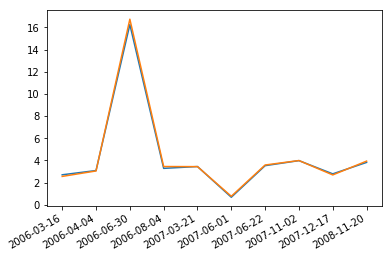

In [143]:
stock_dates.sort()
fig, ax = plt.subplots()
ax.plot(stock_dates[10:20], s_pred_abs.detach()[10:20])
ax.plot(stock_dates[10:20], s_y_val_abs.detach()[10:20])
fig.autofmt_xdate()
start, end = ax.get_xlim()
plt.show()

### Testing random unseen stock (skipped over in the data loading stage)

tensor(0.1389, grad_fn=<MseLossBackward>)


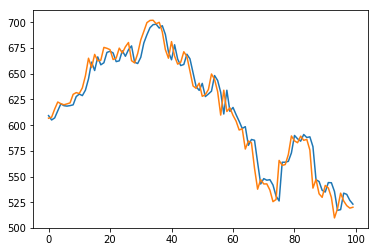

In [135]:
seq = []
test_y = []
test_name_and_date = []
window_size = 122

with open(root_path + "AAPL.txt") as f:
    data = json.load(f)

    temp1 = [] # for prices
    temp2 = [] # for name and date

    for k, v in data.items():
        temp1.append(torch.tensor([ float(i[1]) for i in v.items() if i[0] != "5. volume" ]).unsqueeze(0))
        temp2.append(k)

    # reverse so that data is increasing in time
    temp1.reverse()
    temp2.reverse()

    prices = torch.cat(temp1, 0)

    for i in range(len(prices) - window_size - 1):
        seq.append(prices[i:i+window_size].unsqueeze(0))
        test_y.append(prices[i+window_size][3].item()) # predict the closing price
        test_name_and_date.append(['AAPL', temp2[i + window_size + 1]])
        
test_X = torch.cat(seq, 0)
test_y = torch.tensor(test_y).unsqueeze(1) # from (N,) to (N,1)

test_X_mean = torch.mean(test_X, dim=1).unsqueeze(1)
test_X_std = torch.std(test_X, dim=1).unsqueeze(1)

test_X = (test_X - test_X_mean) / test_X_std
test_y = (test_y - test_X_mean[:,:,3]) / test_X_std[:,:,3]

test_pred = model(test_X)
print(criterion(test_pred, test_y))

test_pred = test_pred * test_X_std[:,:,3] + test_X_mean[:,:,3]
test_y = test_y * test_X_std[:,:,3] + test_X_mean[:,:,3]

plt.plot(test_pred.detach()[3000:3100])
plt.plot(test_y[3000:3100])

In [122]:
dates = [i[1] for i in test_name_and_date]
print(dates)
temp_pred = [ i.data[0] for i in test_pred.detach().numpy() ]
temp_y = [ i.data[0] for i in test_y.detach().numpy() ]

['2000-08-29', '2000-08-30', '2000-08-31', '2000-09-01', '2000-09-05', '2000-09-06', '2000-09-07', '2000-09-08', '2000-09-11', '2000-09-12', '2000-09-13', '2000-09-14', '2000-09-15', '2000-09-18', '2000-09-19', '2000-09-20', '2000-09-21', '2000-09-22', '2000-09-25', '2000-09-26', '2000-09-27', '2000-09-28', '2000-09-29', '2000-10-02', '2000-10-03', '2000-10-04', '2000-10-05', '2000-10-06', '2000-10-09', '2000-10-10', '2000-10-11', '2000-10-12', '2000-10-13', '2000-10-16', '2000-10-17', '2000-10-18', '2000-10-19', '2000-10-20', '2000-10-23', '2000-10-24', '2000-10-25', '2000-10-26', '2000-10-27', '2000-10-30', '2000-10-31', '2000-11-01', '2000-11-02', '2000-11-03', '2000-11-06', '2000-11-07', '2000-11-08', '2000-11-09', '2000-11-10', '2000-11-13', '2000-11-14', '2000-11-15', '2000-11-16', '2000-11-17', '2000-11-20', '2000-11-21', '2000-11-22', '2000-11-24', '2000-11-27', '2000-11-28', '2000-11-29', '2000-11-30', '2000-12-01', '2000-12-04', '2000-12-05', '2000-12-06', '2000-12-07', '2000

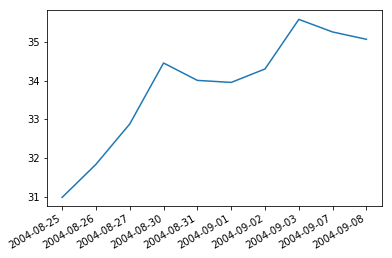

In [131]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots()
ax.plot(dates[1000:1010], temp_pred[1000:1010])
fig.autofmt_xdate()
start, end = ax.get_xlim()
plt.show()

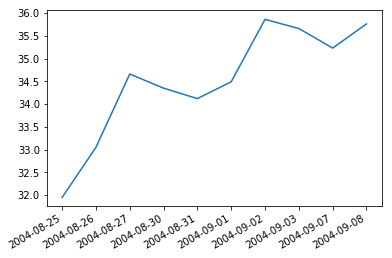

In [133]:
fig, ax = plt.subplots()
ax.plot(dates[1000:1010], temp_y[1000:1010])
fig.autofmt_xdate()
start, end = ax.get_xlim()
plt.show()